# Problem Description

* A large company that manufactures eatables, delivers them through a group of suppliers to retailers of different kinds all over the country.
One of the company’s recent sustainable initiatives was to sell eatable products with no preservatives. These consumables have a shelf life of one week.

* The company, to ensure the quality of its products on retailers’ shelves, creates a program to buy back the remaining products on the shelves of the retailers post expiry (one week).
This has significantly increased the company’s operation costs and is also affecting its gross margins.

* The company has hired you as a data science consultant and provides you with 5 weeks of data. You are now supposed to predict the demand for various products across for the next two weeks. You are also supposed to produce a report using your machine learning model and the 5th week’s data as a validation set to analyze the potential loss in revenue / gain in operational costs.

## Importing reqiured libraries

In [0]:
import numpy as np
import scipy as sp
import pandas as pd
import dateutil.parser as dparser
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.offline as pyoff
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Description

* experiment_week : The column identifying the week during which the data was collected
* channel_type : The channel through which the product is being sold, such as ‘Warehouse Retailers’, ‘grocery stores’, etc.
* num_units_sold_in_week: ​Number of units of the particular product sold that week
* sales_revenue_in_week: ​Revenue that the company made by the sale of the products
* num_units_returned: ​The number of units returned by the retailer for the products sold that week. (Sometimes due to the retailers stocking the products for longer and returning products purchased from prior weeks this variable might be higher than the num_units_sold_in_week)
* returned_units_revenue_loss: ​The amount of money that the company paid the retailer for returning the product
* store_identifier: ​Anonymized identifier of the retailer
* product_identifier: ​Product key from the database
* category_of_route: ​Type of route used by the supplier to deliver the
products
* supplier_identifier: Anonymized identifier of the supplier distributing the
product to the retailer. Most stores have a single supplier, sometimes a
store might have two suppliers.
* demand_projection: ​This is the target attribute, that is supposed to generate by subtracting the number of units returned from the number of units sold.

### Mount goole drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Importing data

In [3]:
#skiprows=lambda i: i>0 and random.random() > 0.01
data=pd.read_csv('/content/gdrive/My Drive/train.csv', header=0)
data.head()

,experiment_week,channel_type,num_units_sold_in_week,sales_revenue_in_week,num_units_returned,returned_units_revenue_loss,store_identifier,product_identifier,category_of_route,supplier_identifier
0,Week 1 of 2019,Warehouse Retailers,3,377.1,0,0.0,store_fc6aa,product_cbfad,route_67047,supplier_identifier_055f7
1,Week 1 of 2019,Warehouse Retailers,4,502.8,0,0.0,store_fc6aa,product_2b363,route_67047,supplier_identifier_055f7
2,Week 1 of 2019,Warehouse Retailers,4,589.8,0,0.0,store_fc6aa,product_8de14,route_67047,supplier_identifier_055f7
3,Week 1 of 2019,Warehouse Retailers,4,502.8,0,0.0,store_fc6aa,product_1c00e,route_67047,supplier_identifier_055f7
4,Week 1 of 2019,Warehouse Retailers,3,343.8,0,0.0,store_fc6aa,product_55001,route_67047,supplier_identifier_055f7


In [4]:
data.shape

(53364883, 10)

### Generating column 'demand_projection'
* 'demand_projection' is generated by subtracting 'num_units_returned' by 'num_units_sold_in_week'

In [0]:
data['demand_projection'] = data.num_units_sold_in_week - data.num_units_returned

### Column data types

In [6]:
data.dtypes

experiment_week                 object
channel_type                    object
num_units_sold_in_week           int64
sales_revenue_in_week          float64
num_units_returned               int64
returned_units_revenue_loss    float64
store_identifier                object
product_identifier              object
category_of_route               object
supplier_identifier             object
demand_projection                int64
dtype: object

### Converting column 'experiment_week' to date format
* Date format in dataset is [Week %week_number of %year]

In [7]:
data.experiment_week = pd.to_datetime(data.experiment_week + '1', format='Week %W of %Y%w')
data.head()

,experiment_week,channel_type,num_units_sold_in_week,sales_revenue_in_week,num_units_returned,returned_units_revenue_loss,store_identifier,product_identifier,category_of_route,supplier_identifier,demand_projection
0,2019-01-07,Warehouse Retailers,3,377.1,0,0.0,store_fc6aa,product_cbfad,route_67047,supplier_identifier_055f7,3
1,2019-01-07,Warehouse Retailers,4,502.8,0,0.0,store_fc6aa,product_2b363,route_67047,supplier_identifier_055f7,4
2,2019-01-07,Warehouse Retailers,4,589.8,0,0.0,store_fc6aa,product_8de14,route_67047,supplier_identifier_055f7,4
3,2019-01-07,Warehouse Retailers,4,502.8,0,0.0,store_fc6aa,product_1c00e,route_67047,supplier_identifier_055f7,4
4,2019-01-07,Warehouse Retailers,3,343.8,0,0.0,store_fc6aa,product_55001,route_67047,supplier_identifier_055f7,3


### Null values count
 * No missing value in dataset

In [8]:
data.isnull().sum()

experiment_week                0
channel_type                   0
num_units_sold_in_week         0
sales_revenue_in_week          0
num_units_returned             0
returned_units_revenue_loss    0
store_identifier               0
product_identifier             0
category_of_route              0
supplier_identifier            0
demand_projection              0
dtype: int64

### Splitting category and numerical attributes

In [9]:
catAttributes = []
numAttributes = []
for i in range(len(data.dtypes)):
  if data.dtypes.keys()[i] == 'experiment_week':
    continue
  if data.dtypes[i] == 'object':
    catAttributes.append(data.dtypes.keys()[i])
  else:
    numAttributes.append(data.dtypes.keys()[i])

catAttributes, numAttributes

(['channel_type',
  'store_identifier',
  'product_identifier',
  'category_of_route',
  'supplier_identifier'],
 ['num_units_sold_in_week',
  'sales_revenue_in_week',
  'num_units_returned',
  'returned_units_revenue_loss',
  'demand_projection'])

### Converting required variable into categorical datatype

In [10]:
for col in catAttributes:
    data[col] = data[col].astype('category')
data.dtypes

experiment_week                datetime64[ns]
channel_type                         category
num_units_sold_in_week                  int64
sales_revenue_in_week                 float64
num_units_returned                      int64
returned_units_revenue_loss           float64
store_identifier                     category
product_identifier                   category
category_of_route                    category
supplier_identifier                  category
demand_projection                       int64
dtype: object

### Stats summary
* There are total 5 week data from 2019-01-07 to 2019-02-04, with most of data from 2019-01-07 (1st week).
* There are total of 9 channel types from where product are being sold, with 'Grocery Stores' being majority point of sale.
* 587773 unique stores, 1736 unique products, 3490 way of routes to supply product and 552 unique suppliers.

In [11]:
data.describe(include='all')

,experiment_week,channel_type,num_units_sold_in_week,sales_revenue_in_week,num_units_returned,returned_units_revenue_loss,store_identifier,product_identifier,category_of_route,supplier_identifier,demand_projection
count,53364883,53364883,5.336488e+07,5.336488e+07,5.336488e+07,5.336488e+07,53364883,53364883,53364883,53364883,5.336488e+07
unique,5,9,NaN,NaN,NaN,NaN,587773,1736,3490,552,NaN
top,2019-01-07 00:00:00,Grocery Stores,NaN,NaN,NaN,NaN,store_384b1,product_1c00e,route_3b474,supplier_identifier_dc4bc,NaN
freq,11165207,48547255,NaN,NaN,NaN,NaN,88430,1560863,337586,582417,NaN
first,2019-01-07 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2019-02-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,7.304088e+00,1.027445e+03,1.230928e-01,1.219568e+00,NaN,NaN,NaN,NaN,7.180995e+00
std,NaN,NaN,2.189756e+01,5.128563e+03,4.223174e+00,3.932746e+01,NaN,NaN,NaN,NaN,2.207857e+01
min,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,-1.634500e+04
25%,NaN,NaN,2.000000e+00,2.514000e+02,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,2.000000e+00


## Visualization and Exploratory Data Analysis

### Defining all functions for plotting graphs

In [0]:
def boxPlot(numColumn, catColumn):
  plt.rcParams['figure.figsize'] = (20.0, 10.0)
  plt.title('Box plot for ' +numColumn+ ' per '+catColumn)
  sns.set(style="whitegrid")
  ax = sns.boxplot(x=catColumn, y=numColumn, data=data)

  for i,artist in enumerate(ax.artists):
      # Set the linecolor on the artist to the facecolor, and set the facecolor to None
      col = artist.get_facecolor()
      artist.set_edgecolor(col)
      artist.set_facecolor('None')

      # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
      # Loop over them here, and use the same colour as above
      for j in range(i*6,i*6+6):
          line = ax.lines[j]
          line.set_color(col)
          line.set_mfc(col)
          line.set_mec(col)

def lineGraph(x, y, graphTitle, colour):
  temp = data.groupby(x)[y].agg('sum')
  temp = temp.reset_index()
  temp.columns = [x,'Sum']
  plotData = [go.Scatter(x = temp[x],
                    y= temp['Sum'],
                    text = temp['Sum'], 
                    textposition = 'top center',
                    line = dict(color = colour)
                    )]

  layout = go.Layout(title = graphTitle,
                    width = 1200,
                    height = 600,
                    yaxis = dict(title= y),
                    xaxis = dict(title= x))
  fig = go.Figure(plotData,layout=layout)
  iplot(fig)
  del temp

def barGraph(x):
  temp = data[x].value_counts()
  trace = go.Bar(x=temp.index,
                y= np.round(temp.astype(float),2),
                text = np.round(temp.astype(float)/temp.values.sum(),3),
                textposition = 'auto',
                name = x)
  plotData = [trace]
  layout = go.Layout(
      autosize=False,
      width=1200,
      height=600,
      title = 'Over all '+x+' count',
      yaxis = dict(title='Total Count'),
      xaxis = dict(title=x)
  )

  fig = go.Figure(plotData, layout=layout)
  iplot(fig)
  del temp

def multiBarGraph(x):
  temp = data.groupby(x).size().to_frame()
  temp = temp.reset_index()
  x.append('Count')
  temp.columns = x

  trace = []
  for cat in temp[x[1]].unique():
    trace.append(go.Bar(x = temp[x[0]][temp[x[1]]==cat],
                  y = temp.Count[temp[x[1]]==cat],
                    text = temp.Count[temp[x[1]]==cat],
                    textposition = 'auto',
                  name = cat))

  plotData = trace
  layout = go.Layout(width = 1200,
                    height = 600,title = x[1]+' count for '+x[0],
                    yaxis = dict(title='Total Count'),
                    xaxis = dict(title= x[0]))
  fig = go.Figure(plotData, layout=layout)
  iplot(fig)
  del temp

def multiLineGraph(x, y, graphTitle):
  temp = data.groupby(x)[y].agg('sum')
  temp = temp.reset_index()
  x.append('Sum')
  temp.columns = x

  trace = []
  for cat in temp[x[1]].unique():
    trace.append(go.Scatter(x = temp[x[0]][temp[x[1]]==cat],
                  y = temp.Sum[temp[x[1]]==cat],
                    text = temp.Sum[temp[x[1]]==cat],
                    textposition = 'top center',
                    name = cat))

  plotData = trace

  layout = go.Layout(title = graphTitle,
                    width = 1200,
                    height = 600,
                    yaxis = dict(title='Sum'),
                    xaxis = dict(title=x[0]))
  fig = go.Figure(plotData,layout=layout)
  iplot(fig)
  del temp

### Boxplot for units sold in week for each experiment weeks

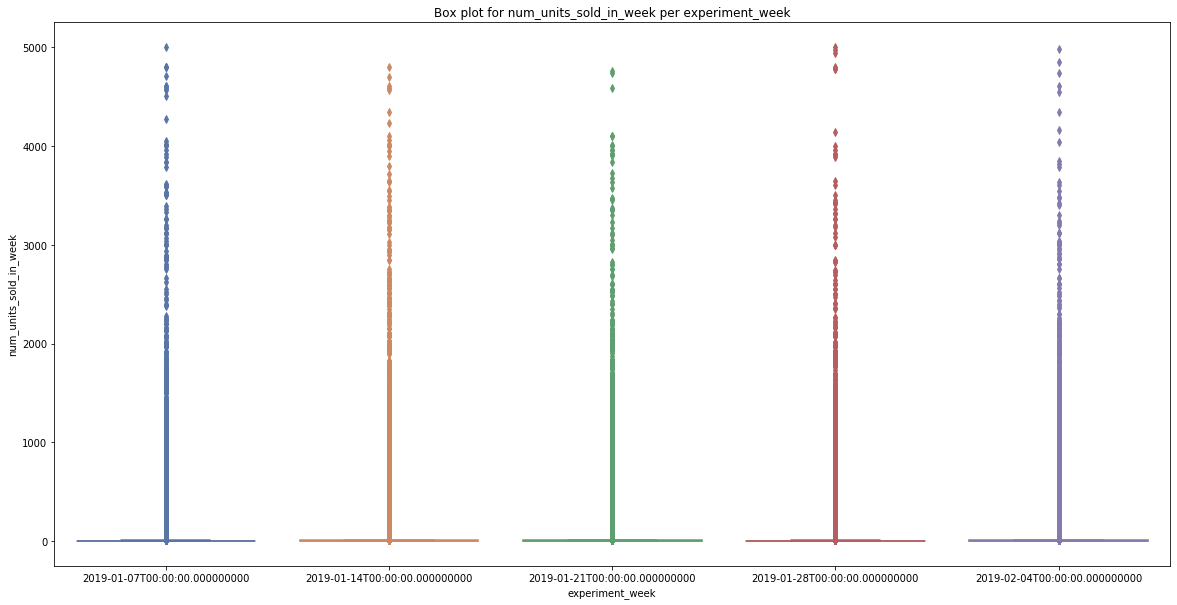

In [13]:
boxPlot('num_units_sold_in_week', 'experiment_week')

### Boxplot for units returned for each experiment weeks

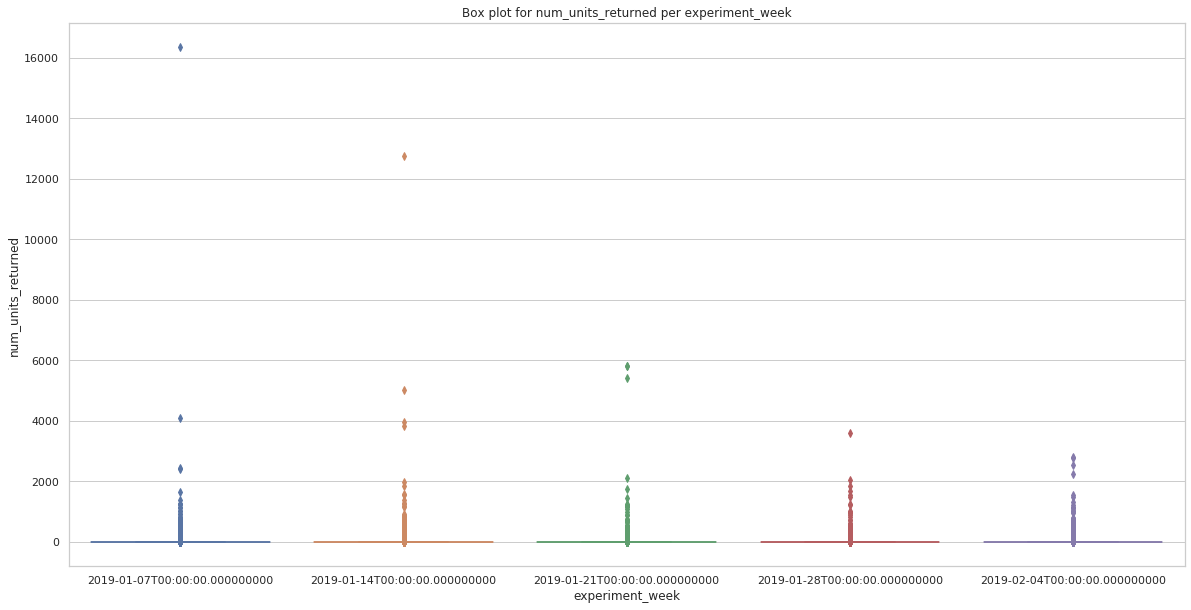

In [14]:
boxPlot('num_units_returned', 'experiment_week')

### Boxplot for projected demand for each experiment weeks

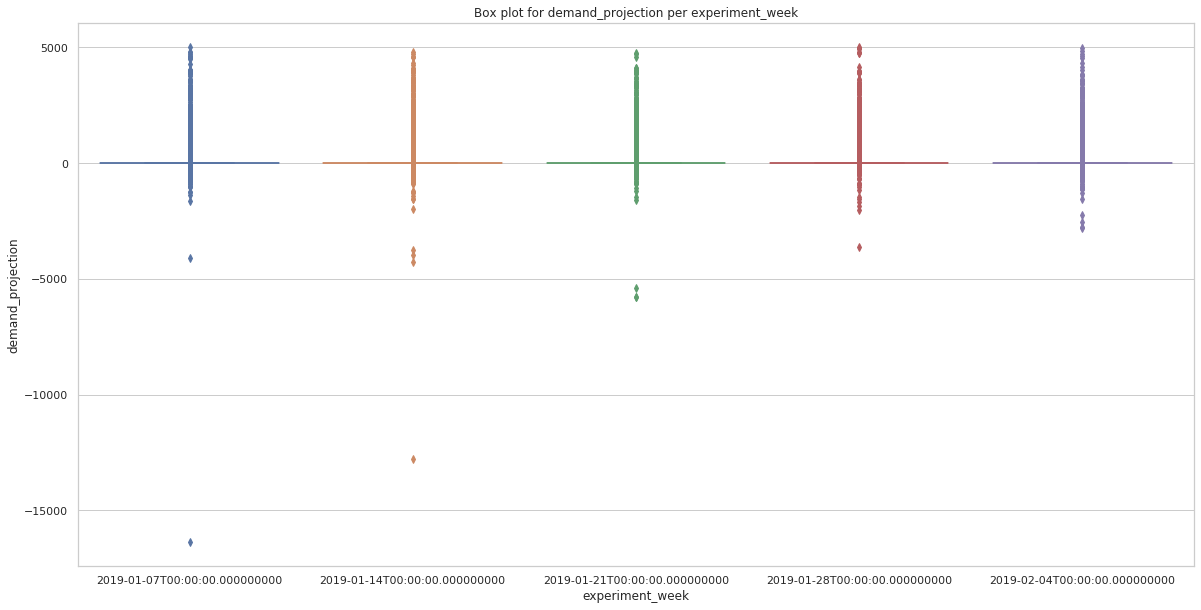

In [15]:
boxPlot('demand_projection', 'experiment_week')

### Line graph for units sold in week, units returned and projected demand for each experiment weeks

In [16]:
lineGraph('experiment_week', 'num_units_sold_in_week', 'Total number of units Sold in week', 'green')
lineGraph('experiment_week', 'num_units_returned', 'Total number of units Returned in week', 'red')
lineGraph('experiment_week', 'demand_projection', 'Total number of units Demand in week', 'blue')

### Generating a new feature 'demand_projection_revenue'.
* By subtracting revenue of units returned from revenue of units sold in that week.

In [0]:
data['demand_projection_revenue'] = data['sales_revenue_in_week'] - data['returned_units_revenue_loss']
numAttributes.append('demand_projection_revenue')

### Line graph for revenues generated or loss by units sold in week, units returned and demand for each experiment weeks

In [18]:
lineGraph('experiment_week', 'sales_revenue_in_week', 'Total Sales revenue', 'green')
lineGraph('experiment_week', 'returned_units_revenue_loss', 'Total revenue loss', 'red')
lineGraph('experiment_week', 'demand_projection_revenue', 'Overall revenue', 'blue')

### Bar chart for channel types count in dataset
* It contains count for each channel type with ratio of same in overall of dataset

In [19]:
barGraph('channel_type')

### Bar chart for channel types count for each week

* It contains count for each channel type with ratio of same in each week of dataset.
* Double click on index menu to switch view of the channel types.

In [20]:
multiBarGraph(['experiment_week', 'channel_type'])

### Multi-line graph for units sold by channel type in each week

In [21]:
multiLineGraph(['experiment_week', 'channel_type'], 'num_units_sold_in_week', 'Total number of unit sold by each Channel Type')

### Multi-line graph for units returned by channel type in each week

In [22]:
multiLineGraph(['experiment_week', 'channel_type'], 'num_units_returned', 'Total number of unit returned by each Channel Type')

### Multi-line graph for demand by channel type in each week

In [23]:
multiLineGraph(['experiment_week', 'channel_type'], 'demand_projection', 'Total number of demand by each Channel Type')

### Defining all function to check perfomance by various categories
* Functions like top revenues by, top sales by, high returns by, low returns by, top loser in percentage.

In [0]:
def rankBarGraph(x, y, tempData, graphTitle):
  temp = tempData[y]
  trace = go.Bar(x=temp.index,
                y= np.round(temp.astype(float),2),
                text = np.round(temp.astype(float),2),
                textposition = 'auto',
                name = x)
  plotData = [trace]
  layout = go.Layout(
      autosize=False,
      width=900,
      height=600,
      title = graphTitle + x,
      yaxis = dict(title= y),
      xaxis = dict(title= x)
  )

  fig = go.Figure(plotData, layout=layout)
  iplot(fig)
  del temp

def topRevenuesBy(columnName,rank=5):
  temp = data.groupby(columnName)['demand_projection_revenue'].agg('sum')
  temp = temp.reset_index()
  temp.sort_values(by=['demand_projection_revenue'], inplace=True, ascending=False)
  temp = temp.set_index(columnName)
  temp = temp.head(rank)
  rankBarGraph(columnName, 'demand_projection_revenue', temp, 'Top '+str(rank)+' revenue by ')

def topSalesBy(columnName, rank=5):
  temp = data.groupby(columnName)['num_units_sold_in_week'].agg('sum')
  temp = temp.reset_index()
  temp.sort_values(by=['num_units_sold_in_week'], inplace=True, ascending=False)
  temp = temp.set_index(columnName)
  temp = temp.head(rank)
  rankBarGraph(columnName, 'num_units_sold_in_week', temp, 'Top '+str(rank)+' unit Sales by ')

def highReturnsBy(columnName, rank=5):
  temp = data.groupby(columnName)['num_units_returned'].agg('sum')
  temp = temp.reset_index()
  temp.sort_values(by=['num_units_returned'], inplace=True, ascending=False)
  temp = temp.set_index(columnName)
  temp = temp.head(rank)
  rankBarGraph(columnName, 'num_units_returned', temp, 'High returns by ')

def lowReturnsBy(columnName, rank=5):
  temp = data.groupby(columnName)['num_units_returned'].agg('sum')
  temp = temp.reset_index()
  temp.sort_values(by=['num_units_returned'], inplace=True, ascending=True)
  temp = temp.set_index(columnName)
  temp = temp.head(rank)
  rankBarGraph(columnName, 'num_units_returned', temp, 'Low returns by ')

def topLoserBy(columnName, rank=5):
  temp = data.groupby(['experiment_week',columnName])['demand_projection_revenue'].agg('sum')
  temp = temp.reset_index()
  temp.sort_values(by=['demand_projection_revenue'], inplace=True, ascending=False)
  temp = temp.set_index('experiment_week')
  temp.demand_projection_revenue = temp.demand_projection_revenue.fillna(0)
  change = []
  for cat in temp[columnName].unique():
    week1 = temp[temp[columnName] == cat].get_value('2019-01-07', 'demand_projection_revenue')
    week5 = temp[temp[columnName] == cat].get_value('2019-02-04', 'demand_projection_revenue')
    if (week5 > week1 and week1 < 0):
      week1 = abs(week1)
    elif(week1 == 0):
      continue
    percentChange = np.round(((week5 - week1)/week1 * 100),5)
    change.append([cat, percentChange])

  temp = pd.DataFrame(change, columns = [columnName, 'precent_change'])
  temp = temp.set_index(columnName)

  temp.sort_values(by=['precent_change'], inplace=True, ascending=True)
  temp = temp.head(rank)
  rankBarGraph(columnName, 'precent_change', temp, 'Top '+str(rank)+' Loser by ')

### Top revenue generated for each categorical attributes.

In [25]:
for col in catAttributes:
  topRevenuesBy(col)

### Top sales for each categorical attributes.

In [26]:
for col in catAttributes:
  topSalesBy(col)

### High returns for each categorical attributes.

In [27]:
for col in catAttributes:
  highReturnsBy(col)

### Low returns for each categorical attributes.

In [28]:
for col in catAttributes:
  lowReturnsBy(col,20)

### Bottom 5 channel types by change in revenue perecentage.

In [29]:
topLoserBy('channel_type')

### Bottom 10 suppliers by change in revenue perecentage.

In [30]:
topLoserBy('supplier_identifier',10)

### Bottom 10 products by change in revenue perecentage.

In [31]:
topLoserBy('product_identifier',10)